In [1]:
import sys
sys.path.append('../')

import tquant as tq
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import numpy as np 
import tensorflow as tf
import QuantLib as ql


def get_ql_curve(curve_tq: tq.RateCurve, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    dates_ql = [evaluation_date_ql] + [evaluation_date_ql + d for d in curve_tq._pillar_days]
    rates_ql = [curve_tq.inst_fwd(0).numpy()] + [r.numpy() for r in curve_tq._rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql

def makeVanillaSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    end = maturity# ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("12M")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Actual360()
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Forward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Forward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap

def getfixed(swap, evaluation_date):
    fix_leg = swap.fixedLeg()
    n = len(fix_leg)
    ref_starts = []
    ref_ends = []
    accrual_starts = []
    accrual_ends = []
    accrual_periods = []
    payments = []
    nominals = []
    rates = []
    amounts = []
    daycounter = []


    for i in range(n):
        cf = ql.as_fixed_rate_coupon(fix_leg[i])

        accrual_starts.append(cf.accrualStartDate())
        accrual_ends.append(cf.accrualEndDate())
        ref_starts.append(cf.referencePeriodStart())
        ref_ends.append(cf.referencePeriodEnd())
        daycounter.append(cf.dayCounter().name())
        accrual_periods.append(cf.accrualPeriod())
        payments.append(cf.date())
        nominals.append(cf.nominal())
        rates.append(cf.rate())
        amounts.append(cf.amount())
        
    display_flows = pd.DataFrame([accrual_starts, accrual_ends,
                                ref_starts, ref_ends, daycounter, accrual_periods,
                                payments, nominals, rates,
                                amounts]).T
    display_flows.columns = ["accr_start", "accr_end",
                            "ref_start", "ref_end", "dc", "accrual",
                             "pay_date", "nominal",
                             "rate", "amount"]
    return display_flows[display_flows['pay_date'] >= evaluation_date]

def getfloating(swap, evaluation_date):

    float_leg = swap.floatingLeg()
    n = len(float_leg)
    ref_starts = []
    ref_ends = []
    accrual_starts = []
    accrual_ends = []
    accrual_periods = []
    fixings = []
    payments = []
    nominals = []
    rates = []
    amounts = []
    convexity = []
    daycounter = []
    spreads = []
    gearings = []
    index = []

    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])

        accrual_starts.append(cf.accrualStartDate())
        accrual_ends.append(cf.accrualEndDate())
        ref_starts.append(cf.referencePeriodStart())
        ref_ends.append(cf.referencePeriodEnd())
        daycounter.append(cf.dayCounter().name())
        accrual_periods.append(cf.accrualPeriod())
        fixings.append(cf.fixingDate())
        payments.append(cf.date())
        nominals.append(cf.nominal())
        index.append(cf.index().name())
        rates.append(cf.indexFixing())
        spreads.append(cf.spread())
        gearings.append(cf.gearing())
        amounts.append(cf.amount())
        convexity.append(cf.convexityAdjustment())
        
    display_flows = pd.DataFrame([accrual_starts, accrual_ends,
                                ref_starts, ref_ends, daycounter, accrual_periods,
                                fixings, payments, nominals, index, rates, spreads, gearings,
                                amounts, convexity]).T
    display_flows.columns = ["accr_start", "accr_end",
                            "ref_start", "ref_end", "dc", "accrual",
                            "fixing_date", "pay_date", "nominal",
                             "index", "rate", "spread", "gearing", "amount", "convexity"]
    return display_flows[display_flows['pay_date'] >= evaluation_date]


# Market

In [2]:
market_data = {}

ref_date = date(2024, 7, 31)
daycounter_convention = tq.DayCounterConvention.ActualActual
daycounter = tq.DayCounter(daycounter_convention )
calendar = tq.TARGET()

mkt = pd.read_excel("market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(ref_date, d) for d in eur6m_df['end']]
#tq
market_data['EUR:ESTR'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=estr_df['end'],
                                    rates=rates,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)
market_data['EUR:6M'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=eur6m_df['end'],
                                    rates=rates_6m,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)

# pricing t0

In [3]:
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR, 2)
first_fixing = 0.03
eur6m_index.add_fixing(date(2024,7,31), first_fixing)

start_date = date(2024,8,2)
end_date = date(2034,8,2)
fixed_rate = 0.01
notional = 100e6
dc_fix = tq.DayCounter(tq.DayCounterConvention.Actual360)
dc_flt = tq.DayCounter(tq.DayCounterConvention.Actual360)
start_dates_fix = [date(2024, 8, 2),
                date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2)]
end_dates_fix = [date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2),
                date(2034, 8, 2)]
pay_dates_fix = [date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2),
                date(2034, 8, 2)]
start_dates_flt = [date(2024, 8, 2),
                date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2)]
end_dates_flt = [date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2),
                date(2034, 8, 2)]
pay_dates_flt = [date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2),
                date(2034, 8, 2)]
swap = tq.Swap(tq.Currency.EUR,
        start_date, end_date,
        start_dates_fix, end_dates_fix, pay_dates_fix,
        start_dates_flt, end_dates_flt, pay_dates_flt,
        fixed_rate,notional, dc_fix, dc_flt, eur6m_index)

In [4]:
swap_engine = tq.SwapPricer(tq.curve_map)
npv_swap, tape = swap_engine.price(swap, ref_date, market_data, True)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 8,878,379
NPV FloatingLeg: 22,692,468
NPV Swap: 13,814,088


## debugging vs QL

In [5]:
estr_ql = get_ql_curve(market_data['EUR:ESTR'], ref_date)
eur6m_ql = get_ql_curve(market_data['EUR:6M'], ref_date)
handleYieldTermStructure = ql.YieldTermStructureHandle(estr_ql)
forecastingCurve = ql.RelinkableYieldTermStructureHandle(eur6m_ql)
index_ql = ql.Euribor6M(forecastingCurve)
calendar_ql = ql.TARGET()
index_ql.addFixing(ql.Date(31,7,2024), first_fixing) 

start_date_ql = ql.Date.from_date(swap.start_date) 
end_date_ql = ql.Date.from_date(swap.maturity)
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)

swap_ql2 = makeVanillaSwap(start_date_ql, end_date_ql, swap.notional, swap.quote, index_ql )
swap_ql2.setPricingEngine(engine)
print(f"NPV QL Swap: {swap_ql2.NPV() :,.0f}")
print(f"NPV TQ Swap: {npv_swap :,.0f}")
print(20*"*")
print(f"NPV QL FixedLeg: {swap_ql2.fixedLegNPV() :,.0f}")
print(f"NPV TQ FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV QL FloatingLeg: {swap_ql2.floatingLegNPV() :,.0f}")
print(f"NPV TQ FloatingLeg: {swap_engine.pv_flt :,.0f}")

NPV QL Swap: 13,838,939
NPV TQ Swap: 13,814,088
********************
NPV QL FixedLeg: -8,895,458
NPV TQ FixedLeg: 8,878,379
NPV QL FloatingLeg: 22,734,397
NPV TQ FloatingLeg: 22,692,468


In [6]:
ql_float = getfloating(swap_ql2, ql.Date(31,7,2024))
ql_fixed = getfixed(swap_ql2,ql.Date(31,7,2024) )
tq_fixed = swap.fixed_leg.display_flows()
tq_float = swap.floating_leg.display_flows()

# simulation

In [7]:
# pre-calibrated
a = 0.14
sigma = 0.008

hw_model = tq.HullWhiteProcess(market_data['EUR:ESTR'], a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(ref_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(ref_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

n_path = 1000
exp_gen = tq.SwapExposureGenerator(hw_model, date_grid)
exp_gen.simulate(n_path, swap, first_fixing)

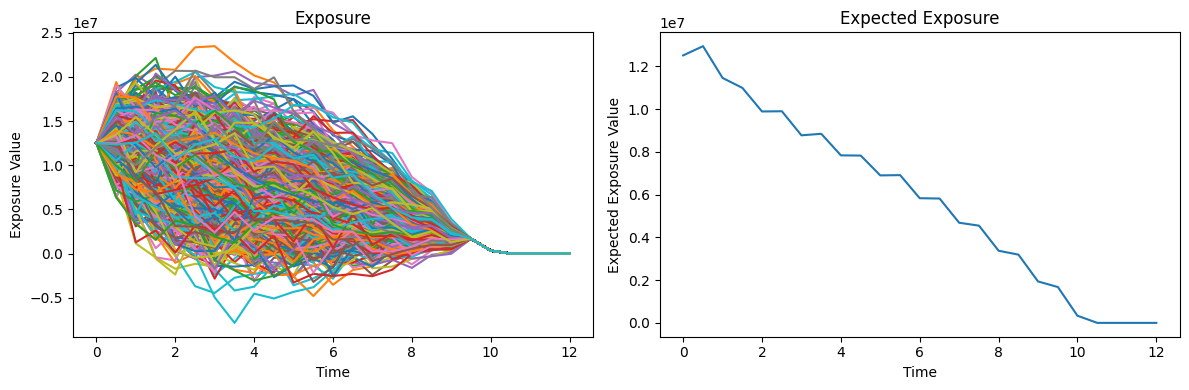

In [8]:
exposure = exp_gen.exposure
ee = exp_gen.expected_exposure

fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 

ax[0].plot(date_grid.times[:25], exposure[:25,:])
ax[0].set_title("Exposure")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Exposure Value")

ax[1].plot(date_grid.times[:25], ee[:25])
ax[1].set_title("Expected Exposure")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Expected Exposure Value")

plt.tight_layout()  # Adjust spacing between plots
plt.show()

## debugging vs QL

In [9]:
def GeneratePaths(process, timeGrid, Npaths):
    
    timestep_len= len(timeGrid[1:])
    dimension = process.factors()
    gen_paths = np.zeros((dimension, timestep_len+1, Npaths))

    rng = ql.UniformRandomSequenceGenerator(dimension * timestep_len, ql.UniformRandomGenerator())
    sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
    pathGenerator = ql.GaussianMultiPathGenerator(process, list(timeGrid), sequenceGenerator, False)

    # paths[0] contiene il primo fattore simulato, paths[1] contiene il secondo, se esiste (es. vola)
    for i in range(Npaths):
        samplePath = pathGenerator.next()
        values = samplePath.value() 

        for j in range(dimension):
            gen_paths[j, :, i] = values[0]
    return gen_paths[0,:,:].T

In [10]:
process = ql.HullWhiteProcess(ql.YieldTermStructureHandle(estr_ql), a, sigma)
model = ql.HullWhite(ql.YieldTermStructureHandle(estr_ql), a, sigma)

paths = GeneratePaths(process, date_grid.times, n_path)

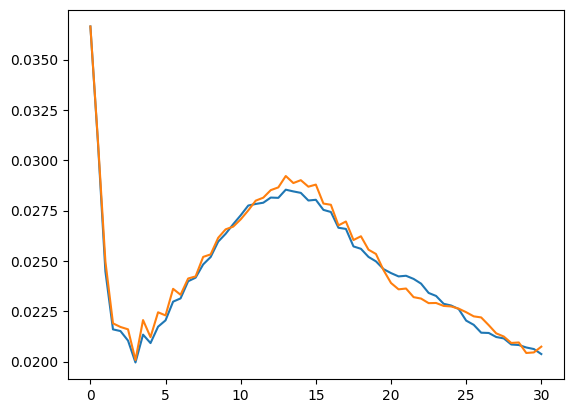

In [11]:
plt.plot(date_grid.times, tf.reduce_mean(exp_gen._kernel._short_rate, axis=0))
plt.plot(date_grid.times, paths.mean(axis=0))
plt.show()

In [12]:
transaction = swap_ql2
scheduleDates = np.array(list(transaction.floatingSchedule()))
transactionFixingDates = np.array([index_ql.fixingDate(scheduleDates[i]) for i in range(scheduleDates.shape[0])])
transactionFixingRates = np.zeros(shape = (transactionFixingDates.shape[0]))

dates_ql = [ql.Date.from_date(d) for d in date_grid.dates]
simulatedFixingDates = np.array(dates_ql) - ql.Period(index_ql.fixingDays(), ql.Days)
simulatedFixingRates = np.mean(paths[:], axis = 0)
simulatedFixingRates[0] = first_fixing

# create fixings lookup table
fixingsLookupTable = {}
for i in range(simulatedFixingDates.shape[0]):
    fixingsLookupTable[simulatedFixingDates[i]] = simulatedFixingRates[i]

# add transaction fixing rates for a given date from fixings lookup table
for i in range(transactionFixingDates.shape[0]):
    if transactionFixingDates[i] in fixingsLookupTable:
        transactionFixingRates[i] = fixingsLookupTable[transactionFixingDates[i]]
    else:
        # find the nearest fixing from lookup table
        transactionFixingRates[i] = \
        fixingsLookupTable.get(transactionFixingDates[i], \
        fixingsLookupTable[min(fixingsLookupTable.keys(), \
        key = lambda d: abs(d - transactionFixingDates[i]))])

# add required transaction fixing dates and rates to floating leg index
index_ql.addFixings(transactionFixingDates, transactionFixingRates, True)

curves = np.zeros(shape = (n_path, len(date_grid.times)), dtype = ql.DiscountCurve)
exposures = np.zeros(shape = (n_path, len(date_grid.times)), dtype = float)
# set the first curve to be current spot market curve
curves[:, 0] = estr_ql
# loop through time steps
bonds_ql = np.zeros((len(date_grid.times), 36, n_path))
for t in range(1, len(date_grid.times)):
    # loop through all paths        
    for s in range(n_path):
        curveDate = dates_ql[t]
        rt = paths[s, t]
        # rt = kernel._short_rate[s,t].numpy()

        curveDates = [curveDate]
        curveDates += [curveDate + ql.Period(i, ql.Days) for i in range(1, 5)]
        curveDates += [curveDate + ql.Period(i, ql.Weeks) for i in range(1, 3)]
        curveDates += [curveDate + ql.Period(i, ql.Months) for i in range(1, 12)]
        curveDates += [curveDate + ql.Period(i, ql.Years) for i in range(1, 15)]
        curveDates += [curveDate + ql.Period(i, ql.Years) for i in [20,25,30,40]]
        curveTaus = [ql.ActualActual(ql.ActualActual.ISDA).yearFraction(curveDate, d) for d in curveDates]

        zeros = np.ones(len(curveDates))
        for k in range(1, len(curveDates)):
            zeros[k] = model.discountBond(date_grid.times[t], date_grid.times[t]+ curveTaus[k], rt)
            bonds_ql[t,k,s] = zeros[k]

        # create a new curve from simulated zero-coupon bond prices
        curves[s, t] = ql.DiscountCurve(curveDates, zeros, ql.Actual360(), ql.TARGET())
        curves[s, t].enableExtrapolation()

In [13]:
# link transaction and pricing engine
discountingCurve = ql.RelinkableYieldTermStructureHandle()
# forecastingCurve = ql.RelinkableYieldTermStructureHandle(eur6m_ql)
swapEngine = ql.DiscountingSwapEngine(discountingCurve)
transaction.setPricingEngine(swapEngine)

# loop through grid time steps
for t in range(len(date_grid.times)):
    # move forward in time along the grid
    ql.Settings.instance().evaluationDate = dates_ql[t]
    # calculate pv for transaction
    # link discounting and forecasting curves to a simulated curve
    for s in range(n_path):
        curve = curves[s][t]
        discountingCurve.linkTo(curve)
        forecastingCurve.linkTo(curve)
        # save pv to exposure matrix
        exposures[s, t] = transaction.NPV()
ee_ql = exposures.mean(axis=0)

In [14]:
ee_ql = exposures.mean(axis=0)

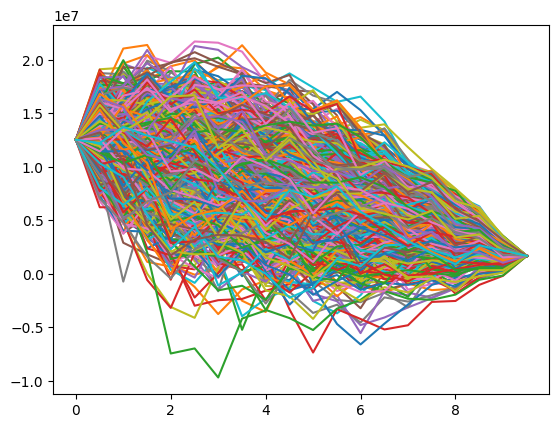

In [15]:
plt.plot(date_grid.times[:20], exposures.T[:20,:]);

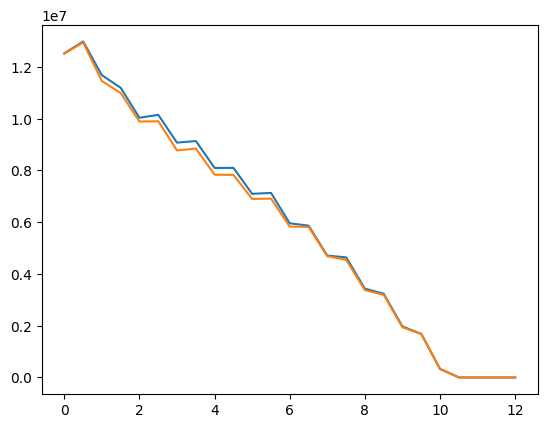

In [16]:
plt.plot(date_grid.times[:25], ee_ql[:25]);
plt.plot(date_grid.times[:25], ee[:25]);